# Project 1 — First Payment Default Prediction

**Name:** Anthony Roca  
**Due:** Feb 18, 2026  

**Evaluation metrics:** We use three benchmarks for model comparison and final evaluation — **Kolmogorov-Smirnov (KS)** > 0.3, **ROC AUC** > 0.7, **Accuracy** > 0.9.



---
## Setup & Imports

Run this section and Section 2 before any model section so that `cv`, `SMOTE_DEFAULT`, and cleaned data are available.

**Tuning and runtime:** We use **3-fold** stratified CV and **reduced hyperparameter grids** for all models so the notebook runs in reasonable time on CPU (e.g. in Colab or on a laptop). This still demonstrates parameter optimization and the base-vs-tuned comparison; for production you could increase folds (e.g. 5) and expand the grids.

In [1]:
import os
import pickle
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline, model_selection, preprocessing, linear_model, svm, ensemble
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.base import clone
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, roc_curve,
    average_precision_score, confusion_matrix, classification_report,
)
import xgboost as xgb
import shap
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

# kaggle competition evaluation: KS > 0.3, ROC AUC > 0.7, Accuracy > 0.9
EVAL_KS_MIN = 0.3
EVAL_ROC_AUC_MIN = 0.7
EVAL_ACC_MIN = 0.9

def ks_score(y_true, y_score):
    """Kolmogorov-Smirnov: max(TPR - FPR) from ROC curve. Requires y_score (e.g. proba for class 1)."""
    fpr, tpr, _ = roc_curve(y_true, y_score)
    return (tpr - fpr).max()

def eval_metrics(estimator, X, y):
    """Return dict with accuracy, f1, roc_auc, ks (uses proba for class 1 when available)."""
    y_pred = estimator.predict(X)
    out = {"accuracy": accuracy_score(y, y_pred), "f1": f1_score(y, y_pred, zero_division=0)}
    if hasattr(estimator, "predict_proba"):
        proba = estimator.predict_proba(X)[:, 1]
        out["roc_auc"] = roc_auc_score(y, proba)
        out["ks"] = ks_score(y, proba)
    return out

# reproducibility and data path (local; same file when opened in Colab)
RANDOM_STATE = 19
DATA_PATH = "kaggle_dataset.csv"

# all outputs go to output/ (create if missing)
OUTPUT_DIR = "output"
os.makedirs(OUTPUT_DIR, exist_ok=True)
# naming convention: models -> output/first_payment_default_<model_name>_model.pkl
# reports -> output/<description>_report.csv or .txt; plots -> output/<description>_plot.png

def save_model(estimator, model_name):
    """Save fitted estimator as pickle to output/ with informative filename."""
    path = os.path.join(OUTPUT_DIR, f"first_payment_default_{model_name}_model.pkl")
    with open(path, "wb") as f:
        pickle.dump(estimator, f)
    return path

# cross-validation and shared resampler (used by all model sections; run this cell before any model cell)
cv = model_selection.StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
SMOTE_DEFAULT = SMOTE(sampling_strategy=0.25, k_neighbors=5, random_state=RANDOM_STATE)

def make_l1_selector(C=0.1, max_iter=1000):
    """L1 LogisticRegression for SelectFromModel (feature selection)."""
    base = linear_model.LogisticRegression(
        penalty="l1", solver="saga", class_weight="balanced",
        random_state=RANDOM_STATE, max_iter=max_iter, C=C
    )
    return SelectFromModel(estimator=base, threshold="median")

def print_val_metrics(model_name, best_params, val_metrics):
    """Print best params and validation metrics in a consistent format."""
    print(f"Best params: {best_params}\nVal — KS: {val_metrics.get('ks', float('nan')):.4f}, ROC AUC: {val_metrics.get('roc_auc', float('nan')):.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}")

def run_base_vs_tuned(pipe_base, best_estimator, X_train_clean, y_train, X_val_clean, y_val, val_metrics, output_key):
    """Compare base (default) vs tuned estimator: fit/predict times and validation metrics; save CSV and print."""
    t0 = time.perf_counter()
    pipe_base.fit(X_train_clean, y_train)
    train_base = time.perf_counter() - t0
    t0 = time.perf_counter()
    pipe_base.predict(X_val_clean)
    test_base = time.perf_counter() - t0
    m_base = eval_metrics(pipe_base, X_val_clean, y_val)
    t0 = time.perf_counter()
    clone(best_estimator).fit(X_train_clean, y_train)
    train_tuned = time.perf_counter() - t0
    t0 = time.perf_counter()
    best_estimator.predict(X_val_clean)
    test_tuned = time.perf_counter() - t0
    comp = pd.DataFrame([
        {"version": "base", "train_time_s": train_base, "test_time_s": test_base, "KS": m_base.get("ks", np.nan), "ROC_AUC": m_base.get("roc_auc", np.nan), "Accuracy": m_base["accuracy"], "F1": m_base["f1"]},
        {"version": "tuned", "train_time_s": train_tuned, "test_time_s": test_tuned, "KS": val_metrics.get("ks", np.nan), "ROC_AUC": val_metrics.get("roc_auc", np.nan), "Accuracy": val_metrics["accuracy"], "F1": val_metrics["f1"]},
    ])
    comp.to_csv(os.path.join(OUTPUT_DIR, f"{output_key}_base_vs_tuned.csv"), index=False)
    print(f"\n{output_key.replace('_', ' ').title()} — base vs tuned (validation set):")
    print(comp.to_string(index=False))

# plot defaults
plt.rcParams["figure.figsize"] = (8, 5)
sns.set_style("whitegrid")

---
## 1. Exploratory Data Analysis (EDA)

Load the data, inspect schema and missing values, check target distribution, and compute correlations. Brief narrative after each block.

### 1.1 Load and schema

Load the dataset and inspect column names, dtypes, and null counts.

In [2]:
# load data
df = pd.read_csv(DATA_PATH)
print(f"Shape: {df.shape}\n")

# feature types summary
print("Feature types (count):")
print(df.dtypes.value_counts().to_string())
print()

# column names + dtypes + null counts
df.info()
print("\nNull counts:")
df.isna().sum()

Shape: (38985, 87)

Feature types (count):
int64      41
float64    40
bool        5
object      1

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38985 entries, 0 to 38984
Data columns (total 87 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_1   38985 non-null  float64
 1   feature_2   38985 non-null  int64  
 2   feature_3   38985 non-null  int64  
 3   feature_4   38985 non-null  int64  
 4   feature_5   36771 non-null  float64
 5   feature_6   36771 non-null  float64
 6   feature_7   36771 non-null  float64
 7   feature_8   38985 non-null  int64  
 8   feature_9   38985 non-null  int64  
 9   feature_10  36771 non-null  float64
 10  feature_11  38985 non-null  float64
 11  feature_12  38985 non-null  float64
 12  feature_13  36771 non-null  float64
 13  feature_14  36771 non-null  float64
 14  feature_15  23258 non-null  float64
 15  feature_16  26095 non-null  float64
 16  feature_17  28240 non-null  float64
 17  feature

feature_1        0
feature_2        0
feature_3        0
feature_4        0
feature_5     2214
              ... 
feature_83       0
feature_84       0
feature_85       0
ID               0
target           0
Length: 87, dtype: int64

**Summary:** Shape, dtypes, and null counts are above. The **target** is binary (default vs no default). **ID** is excluded from features. Object columns will be encoded in the preprocessing step.

### 1.2 Missing values

Count missing values per column and visualize; we will impute (no row/column drops) in Section 2.

Columns with missing values:
feature_50    30487
feature_38    23572
feature_37    22246
feature_36    20105
feature_56    18544
feature_66    18046
feature_15    15727
feature_18    15727
feature_21    15727
feature_52    14301
feature_51    14301
feature_43    14301
feature_49    14301
feature_48    14301
feature_47    14301
feature_53    14301
feature_54    14301
feature_55    14301
feature_46    14301
feature_45    14301
feature_44    14301
feature_39    14301
feature_42    14301
feature_41    14301
feature_40    14301
feature_22    12890
feature_19    12890
feature_16    12890
feature_23    10745
feature_20    10745
feature_17    10745
feature_6      2214
feature_14     2214
feature_13     2214
feature_10     2214
feature_7      2214
feature_5      2214
Total missing fraction: 0.1454


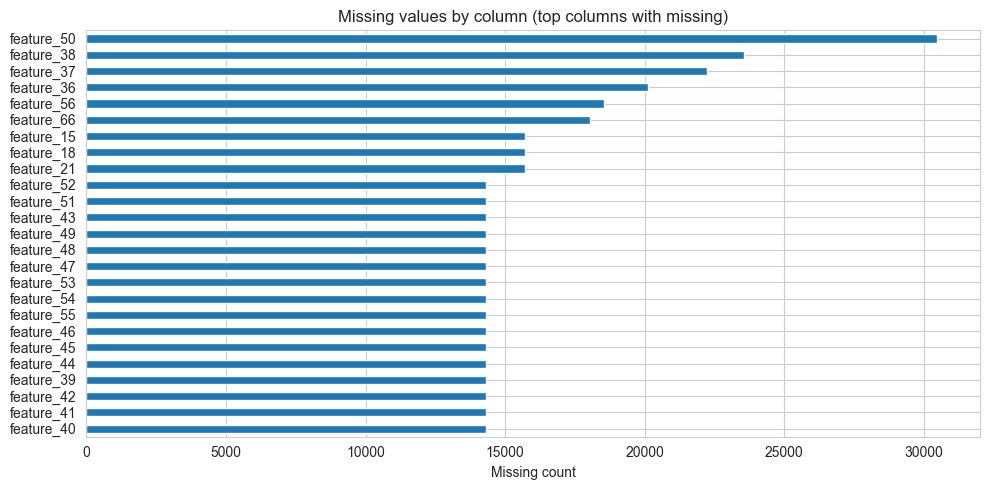

In [3]:
# missing values per column
missing = df.isna().sum()
missing = missing[missing > 0].sort_values(ascending=False)
frac = (df.isna().sum().sum() / df.size) if df.size else 0.0
print(f"Columns with missing values:\n{missing.to_string() if len(missing) else 'None'}\nTotal missing fraction: {frac:.4f}")

# visualization: bar chart of missing counts (top columns with missing)
if len(missing) > 0:
    n_show = min(25, len(missing))
    fig, ax = plt.subplots(figsize=(10, 5))
    missing.head(n_show).iloc[::-1].plot(kind="barh", ax=ax, legend=False)
    ax.set_xlabel("Missing count")
    ax.set_title("Missing values by column (top columns with missing)")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, "eda_missing_values_by_column_plot.png"), dpi=100, bbox_inches="tight")
    plt.show()

**Summary:** Missingness is documented above. We keep all rows/columns and will impute in Section 2 using statistics fit on the training set only (median for numeric, constant for categorical).

### 1.3 Distributions and target balance

Target distribution and class balance; low default rate motivates imbalance-handling later.

Target distribution:
0    37857
1     1128
Target proportion (default=1): 0.0289


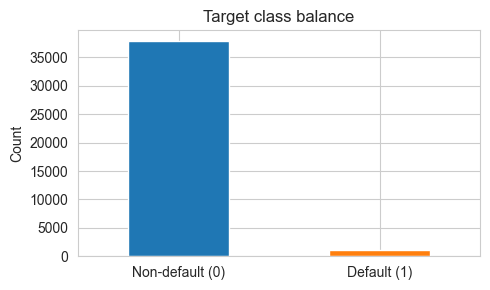

,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,feature_10,...,feature_75,feature_76,feature_77,feature_78,feature_79,feature_80,feature_81,feature_82,feature_84,feature_85
count,3.898500e+04,38985.000000,38985.000000,38985.000000,36771.000000,36771.000000,36771.000000,38985.000000,38985.000000,36771.000000,...,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000,38985.000000
mean,3.484706e+04,45.646197,0.482801,0.524484,600.987651,238.338737,206.265718,6.850045,10.143517,0.592114,...,0.180300,0.405412,3.510248,2.560882,1.191946,0.070976,1.391535,0.990047,74.948185,4.483545
std,3.406895e+04,13.399512,0.499711,0.514086,572.164116,335.988411,392.821775,7.269573,18.639226,1.608102,...,0.503621,0.692286,1.350853,2.103188,1.631621,0.277805,0.598445,0.099266,12.203381,2.889420
min,3.000000e+03,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.020100,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,20.000000,0.000000
25%,1.530924e+04,35.000000,0.000000,0.000000,261.210000,28.428600,0.000000,2.000000,3.000000,0.175800,...,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,1.000000,1.000000,65.000000,2.000000
50%,2.500000e+04,45.000000,0.000000,1.000000,392.000000,108.571400,0.000000,5.000000,6.000000,0.352700,...,0.000000,0.000000,4.000000,3.000000,0.000000,0.000000,1.000000,1.000000,80.000000,5.000000
75%,4.311684e+04,56.000000,1.000000,1.000000,755.500000,269.142900,226.142900,9.000000,12.000000,0.659050,...,0.000000,1.000000,5.000000,5.000000,2.000000,0.000000,2.000000,1.000000,85.000000,7.000000
max,2.081718e+06,76.000000,1.000000,3.000000,4458.310000,2239.428600,2378.714300,186.000000,953.000000,119.868600,...,5.000000,5.000000,5.000000,5.000000,5.000000,3.000000,2.000000,1.000000,100.000000,9.000000


In [4]:
# analyze target distribution
print(f"Target distribution:\n{df['target'].value_counts(dropna=False).to_string()}\nTarget proportion (default=1): {df['target'].mean():.4f}")

# visualization: target class balance
target_counts = df["target"].value_counts(dropna=False)
fig, ax = plt.subplots(figsize=(5, 3))
target_counts.plot(kind="bar", ax=ax, color=["C0", "C1"])
ax.set_xticklabels(["Non-default (0)", "Default (1)"], rotation=0)
ax.set_ylabel("Count")
ax.set_title("Target class balance")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eda_target_balance_plot.png"), dpi=100, bbox_inches="tight")
plt.show()
num_cols = [c for c in df.select_dtypes(include=[np.number]).columns if c != "target"]
df[num_cols].describe()

**Summary:** Strong class imbalance (few defaults). We use SMOTE and class weights in the models and report F1 and ROC AUC in addition to accuracy.

### 1.4 Correlations

Correlations with the target suggest important predictors; correlations between features suggest redundancy and support regularization or feature selection.

Top absolute correlations with target:
feature_71    0.054917
feature_21   -0.041583
feature_15   -0.039942
feature_72    0.039572
feature_2    -0.035768
feature_66   -0.035644
feature_18   -0.035497
feature_16   -0.034915
feature_22   -0.033357
feature_17   -0.031939
feature_10    0.030613
feature_23   -0.029586
feature_8     0.029243
feature_20   -0.029148
feature_28   -0.028975


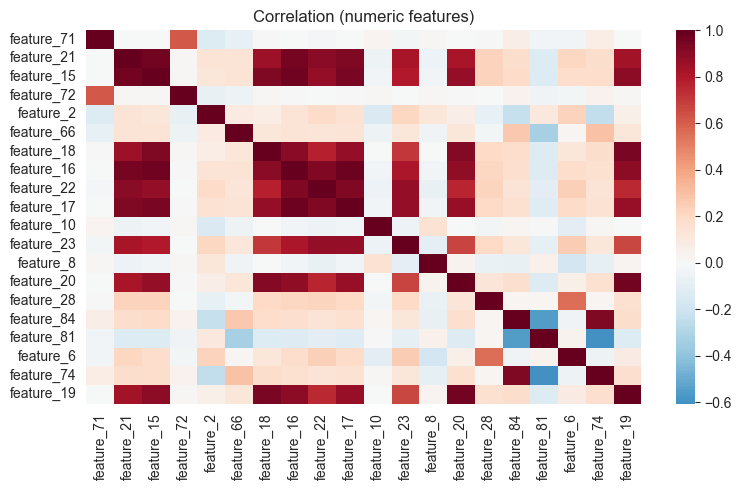

In [5]:
# correlation analysis
corr = df.select_dtypes(include=[np.number]).corr()
target_corr = None
if "target" in corr.columns:
    tc = corr["target"].drop("target", errors="ignore")
    target_corr = tc.loc[tc.abs().sort_values(ascending=False).index]
    print(f"Top absolute correlations with target:\n{target_corr.head(15).to_string()}")
cols_heat = (target_corr.head(20).index.tolist() if target_corr is not None and len(corr.columns) > 20 else corr.columns.tolist())
sns.heatmap(corr.loc[cols_heat, cols_heat], annot=False, cmap="RdBu_r", center=0)
plt.title("Correlation (numeric features)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "eda_correlation_heatmap_plot.png"), dpi=100, bbox_inches="tight")
plt.show()

**Summary:** We use model-based feature selection (L1/SelectFromModel) for some models and tree-based models that handle many features; correlation analysis supports this approach.

---
## 2. Train / Validation / Test Split

Single split: 70% train, 15% validation, 15% test, **stratified** on the target to preserve class balance. Test is held out for one final evaluation only; validation is used for model comparison and reporting; tuning is done via cross-validation on the training set.

In [6]:
# define split ratios
train_ratio, val_ratio, test_ratio = 0.70, 0.15, 0.15

# split data into features and target (without ID)
feature_cols = [c for c in df.columns if c not in ("ID", "target")]
X = df[feature_cols].copy()
y = np.ravel(df[["target"]])

# split data into train and rest
X_train, X_rest, y_train, y_rest = model_selection.train_test_split(
    X, y, train_size=train_ratio, random_state=RANDOM_STATE, stratify=y
)

# split rest into val and test
X_val, X_test, y_val, y_test = model_selection.train_test_split(
    X_rest, y_rest, train_size=0.5, random_state=RANDOM_STATE, stratify=y_rest
)

# print split sizes
n = len(X)
print(f"Train: {X_train.shape[0]} ({100 * X_train.shape[0] / n:.1f}%)\nValidation: {X_val.shape[0]} ({100 * X_val.shape[0] / n:.1f}%)\nTest: {X_test.shape[0]} ({100 * X_test.shape[0] / n:.1f}%)\nTarget balance (train): {np.mean(y_train):.4f}")

Train: 27289 (70.0%)
Validation: 5848 (15.0%)
Test: 5848 (15.0%)
Target balance (train): 0.0289


**Summary:** Split sizes and feature subset (ID and target excluded) are defined above. We do not drop rows or columns here.

### 2.1 Preprocessing (cleaned partition)

We impute and encode rather than drop rows/columns to avoid data loss. **All preprocessing is fit on the training set only** and applied to validation and test to prevent leakage. Choices: **median** imputation for numerics (robust to outliers), **constant** for categoricals (treat missing as a level); **OneHotEncoder** for categoricals; **StandardScaler** for numerics. Outputs: `X_train_clean`, `X_val_clean`, `X_test_clean`.

In [7]:
# column types: numeric (int/float), bool, categorical (object) **ALL FIT ON TRAIN ONLY**
numeric_cols = [c for c in feature_cols if c in X_train.select_dtypes(include=[np.number]).columns]
bool_cols = [c for c in feature_cols if c in X_train.select_dtypes(include=[bool]).columns]
categorical_cols = [c for c in feature_cols if c not in numeric_cols and c not in bool_cols]

# binarizer expects numeric input; cast bool columns to float once so we use only sklearn built-ins
X_train_prep = X_train.copy()
X_val_prep = X_val.copy()
X_test_prep = X_test.copy()
for col in bool_cols:
    X_train_prep[col] = X_train_prep[col].astype(np.float64)
    X_val_prep[col] = X_val_prep[col].astype(np.float64)
    X_test_prep[col] = X_test_prep[col].astype(np.float64)

clean_preprocessor = ColumnTransformer(
    [
        ("num", pipeline.Pipeline([
            ("impute", SimpleImputer(strategy="median")),
            ("scale", preprocessing.StandardScaler()),
        ]), numeric_cols),
        ("bool", preprocessing.Binarizer(threshold=0.5), bool_cols),
        ("cat", pipeline.Pipeline([
            ("impute", SimpleImputer(strategy="constant", fill_value="missing")),
            ("encode", preprocessing.OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
        ]), categorical_cols),
    ],
    remainder="drop",
)

# fit on train only (same transform applied to val/test)
clean_preprocessor.fit(X_train_prep)
X_train_clean = clean_preprocessor.transform(X_train_prep)
X_val_clean = clean_preprocessor.transform(X_val_prep)
X_test_clean = clean_preprocessor.transform(X_test_prep)

print(f"Cleaned shapes: train {X_train_clean.shape}, val {X_val_clean.shape}, test {X_test_clean.shape}")

Cleaned shapes: train (27289, 85), val (5848, 85), test (5848, 85)


**Summary:** Numeric → median impute + scale; bool → binarize to 0/1; categorical → constant impute + one-hot. Fitted on train only; same transform for val/test.

---
## 3. Model 1: Elastic Net Logistic Regression

**Why this model:** Linear model with L1/L2 penalty; interpretable and handles many features via sparsity. **Feature selection:** L1 LogisticRegression with SelectFromModel (threshold="median") to keep a sparse subset and reduce multicollinearity. **Class imbalance:** We use two strategies—(1) **SMOTE** (oversample minority to 25%) inside the pipeline so each CV fold is resampled independently; (2) **class_weight="balanced"** so the loss reflects class frequency. GridSearchCV on train (3-fold CV and reduced grid for runtime; see Setup); best model is evaluated on validation and stored for Section 7.

### 3.1 Pipeline, tuning, evaluation

Pipeline: SMOTE → L1 selector → Elastic Net. GridSearchCV on train; fit best; validation metrics and base-vs-tuned comparison below.

In [9]:
# model 1: Elastic Net — two imbalance techniques: SMOTE (oversample minority) + class_weight='balanced'
# shared list for Section 7 (append from each model)
if "model_results" not in dir():
    model_results = []

pipe_enet = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("select", make_l1_selector(C=0.1, max_iter=2000)),
    ("clf", linear_model.LogisticRegression(penalty="elasticnet", solver="saga", class_weight="balanced", random_state=RANDOM_STATE, max_iter=2000)),
])
param_grid = {
    "select__estimator__C": [0.1, 1.0],
    "clf__C": [0.1, 1.0],
    "clf__l1_ratio": [0.5],
}
search_enet = model_selection.GridSearchCV(pipe_enet, param_grid, cv=cv, scoring="roc_auc", n_jobs=-1)
search_enet.fit(X_train_clean, y_train)
best_enet = search_enet.best_estimator_
val_metrics_enet = eval_metrics(best_enet, X_val_clean, y_val)
model_results.append({"name": "Elastic Net", "key": "elastic_net", "best_estimator": best_enet, "val_metrics": val_metrics_enet})
save_model(best_enet, "elastic_net")
print_val_metrics("Elastic Net", search_enet.best_params_, val_metrics_enet)

# base vs tuned: metrics and train/test time (validation set)
pipe_enet_base = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("select", make_l1_selector(C=0.1, max_iter=2000)),
    ("clf", linear_model.LogisticRegression(penalty="elasticnet", solver="saga", class_weight="balanced", random_state=RANDOM_STATE, max_iter=2000, C=0.1, l1_ratio=0.5)),
])
run_base_vs_tuned(pipe_enet_base, best_enet, X_train_clean, y_train, X_val_clean, y_val, val_metrics_enet, "elastic_net")

/Users/anthonyroca/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonyroca/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonyroca/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonyroca/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonyroca/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/anthonyroca/anaconda3/lib/py

KeyboardInterrupt: 

---
## 4. Model 2: SVM

**Why this model:** SVM with RBF kernel can capture non-linear boundaries; useful when linear models may underfit. **Feature selection:** Same L1/SelectFromModel as in Model 1 to reduce dimensionality and runtime. **Class imbalance:** SMOTE + `class_weight="balanced"`. We use `probability=True` so we can compute KS and ROC AUC. GridSearchCV on train (3-fold, reduced grid; see Setup); best model evaluated on validation and stored for Section 7.

### 4.1 Pipeline, tuning, evaluation

Pipeline: SMOTE → L1 selector → SVM (RBF). GridSearchCV on train; validation metrics and base-vs-tuned below.

In [ ]:
# model 2: SVM — two imbalance techniques: SMOTE + class_weight='balanced'; probability=True for KS/ROC.
pipe_svm = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("select", make_l1_selector(C=0.1, max_iter=1000)),
    ("clf", svm.SVC(kernel="rbf", class_weight="balanced", probability=True, random_state=RANDOM_STATE)),
])
param_grid_svm = {"select__estimator__C": [0.1, 1.0], "clf__C": [1.0, 10.0], "clf__gamma": ["scale"]}
search_svm = model_selection.GridSearchCV(pipe_svm, param_grid_svm, cv=cv, scoring="roc_auc", n_jobs=-1)
search_svm.fit(X_train_clean, y_train)
best_svm = search_svm.best_estimator_
val_metrics_svm = eval_metrics(best_svm, X_val_clean, y_val)
model_results.append({"name": "SVM", "key": "svm", "best_estimator": best_svm, "val_metrics": val_metrics_svm})
save_model(best_svm, "svm")
print_val_metrics("SVM", search_svm.best_params_, val_metrics_svm)

# base vs tuned: metrics and train/test time (validation set)
pipe_svm_base = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("select", make_l1_selector(C=1.0, max_iter=1000)),
    ("clf", svm.SVC(kernel="rbf", C=1.0, gamma="scale", class_weight="balanced", probability=True, random_state=RANDOM_STATE)),
])
run_base_vs_tuned(pipe_svm_base, best_svm, X_train_clean, y_train, X_val_clean, y_val, val_metrics_svm, "svm")

---
## 5. Model 3: Random Forest

**Why this model:** Random Forest handles many features and non-linear relationships without an explicit feature selector; it naturally ranks importance. We skip SelectFromModel here so the trees see all preprocessed features. **Class imbalance:** SMOTE + **class_weight="balanced_subsample"** (weights computed per tree from bootstrap sample). GridSearchCV on train (3-fold, reduced grid; see Setup); best model on validation.

### 5.1 Pipeline, tuning, evaluation

In [ ]:
# model 3: Random Forest — two imbalance techniques: SMOTE + class_weight='balanced_subsample'.
pipe_rf = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("clf", ensemble.RandomForestClassifier(class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1)),
])
param_grid_rf = {"clf__n_estimators": [100, 200], "clf__max_depth": [10, 20], "clf__min_samples_leaf": [2]}
search_rf = model_selection.GridSearchCV(pipe_rf, param_grid_rf, cv=cv, scoring="roc_auc", n_jobs=-1)
search_rf.fit(X_train_clean, y_train)
best_rf = search_rf.best_estimator_
val_metrics_rf = eval_metrics(best_rf, X_val_clean, y_val)
model_results.append({"name": "Random Forest", "key": "random_forest", "best_estimator": best_rf, "val_metrics": val_metrics_rf})
save_model(best_rf, "random_forest")
print_val_metrics("Random Forest", search_rf.best_params_, val_metrics_rf)

# base vs tuned: metrics and train/test time (validation set)
pipe_rf_base = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("clf", ensemble.RandomForestClassifier(n_estimators=100, max_depth=10, min_samples_leaf=2, class_weight="balanced_subsample", random_state=RANDOM_STATE, n_jobs=-1)),
])
run_base_vs_tuned(pipe_rf_base, best_rf, X_train_clean, y_train, X_val_clean, y_val, val_metrics_rf, "random_forest")

---
## 6. Model 4: XGBoost

**Why this model:** Gradient boosting often performs well on tabular data; no explicit feature selector—built-in importance. **Class imbalance:** SMOTE + **scale_pos_weight** set to the ratio (neg/pos) in the training set so the loss up-weights the minority class. GridSearchCV on train (3-fold, reduced grid; see Setup); best model on validation.

### 6.1 Pipeline, tuning, evaluation

In [ ]:
# model 4: XGBoost — two imbalance techniques: SMOTE + scale_pos_weight.
if xgb is None:
    raise ImportError("XGBoost not installed. Run: pip install xgboost")
n_pos = np.sum(y_train == 1)
n_neg = np.sum(y_train == 0)
scale_pos_weight = (n_neg / n_pos) if n_pos > 0 else 1.0
pipe_xgb = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("clf", xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_jobs=-1)),
])
param_grid_xgb = {"clf__n_estimators": [100, 200], "clf__max_depth": [6], "clf__learning_rate": [0.1]}
search_xgb = model_selection.GridSearchCV(pipe_xgb, param_grid_xgb, cv=cv, scoring="roc_auc", n_jobs=-1)
search_xgb.fit(X_train_clean, y_train)
best_xgb = search_xgb.best_estimator_
val_metrics_xgb = eval_metrics(best_xgb, X_val_clean, y_val)
model_results.append({"name": "XGBoost", "key": "xgboost", "best_estimator": best_xgb, "val_metrics": val_metrics_xgb})
save_model(best_xgb, "xgboost")
print_val_metrics("XGBoost", search_xgb.best_params_, val_metrics_xgb)

# base vs tuned: metrics and train/test time (validation set)
pipe_xgb_base = ImbPipeline([
    ("smote", SMOTE_DEFAULT),
    ("clf", xgb.XGBClassifier(n_estimators=100, max_depth=6, learning_rate=0.1, use_label_encoder=False, eval_metric="logloss", scale_pos_weight=scale_pos_weight, random_state=RANDOM_STATE, n_jobs=-1)),
])
run_base_vs_tuned(pipe_xgb_base, best_xgb, X_train_clean, y_train, X_val_clean, y_val, val_metrics_xgb, "xgboost")

---
## 7. Final comparison

We compare all four models on validation and on the **held-out test set** using the three evaluation metrics: KS (> 0.3), ROC AUC (> 0.7), Accuracy (> 0.9). The table and plot show which models meet the benchmarks; we select the best model by test ROC AUC (primary), then KS and accuracy. The selected model is used for Sections 8 and 9.

In [ ]:
# final comparison: validation + test metrics; benchmarks KS>0.3, ROC AUC>0.7, Acc>0.9; select best model.
rows = []
for m in model_results:
    est = m["best_estimator"]
    test_metrics = eval_metrics(est, X_test_clean, y_test)
    row = {
        "model": m["name"],
        "val_KS": m["val_metrics"].get("ks", np.nan),
        "val_ROC_AUC": m["val_metrics"].get("roc_auc", np.nan),
        "val_Accuracy": m["val_metrics"]["accuracy"],
        "val_F1": m["val_metrics"]["f1"],
        "test_KS": test_metrics.get("ks", np.nan),
        "test_ROC_AUC": test_metrics.get("roc_auc", np.nan),
        "test_Accuracy": test_metrics["accuracy"],
        "test_F1": test_metrics["f1"],
    }
    row["meets_KS"] = row["test_KS"] >= EVAL_KS_MIN
    row["meets_ROC_AUC"] = row["test_ROC_AUC"] >= EVAL_ROC_AUC_MIN
    row["meets_Acc"] = row["test_Accuracy"] >= EVAL_ACC_MIN
    rows.append(row)
comparison_df = pd.DataFrame(rows)
print("Validation metrics:")
print(comparison_df[["model", "val_KS", "val_ROC_AUC", "val_Accuracy", "val_F1"]].to_string(index=False))
print("\nTest metrics (out-of-sample):")
print(comparison_df[["model", "test_KS", "test_ROC_AUC", "test_Accuracy", "test_F1"]].to_string(index=False))
print("\nCompetition benchmarks (test): KS>0.3, ROC AUC>0.7, Acc>0.9")
print(comparison_df[["model", "meets_KS", "meets_ROC_AUC", "meets_Acc"]].to_string(index=False))
comparison_df.to_csv(os.path.join(OUTPUT_DIR, "final_comparison_report.csv"), index=False)

# plot test metrics
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
x = np.arange(len(comparison_df))
w = 0.25
ax.bar(x - w, comparison_df["test_KS"], width=w, label="KS")
ax.bar(x, comparison_df["test_ROC_AUC"], width=w, label="ROC AUC")
ax.bar(x + w, comparison_df["test_Accuracy"], width=w, label="Accuracy")
ax.axhline(EVAL_KS_MIN, color="gray", linestyle="--", alpha=0.7)
ax.axhline(EVAL_ROC_AUC_MIN, color="gray", linestyle="--", alpha=0.7)
ax.axhline(EVAL_ACC_MIN, color="gray", linestyle="--", alpha=0.7)
ax.set_xticks(x)
ax.set_xticklabels(comparison_df["model"])
ax.set_ylabel("Score")
ax.legend()
ax.set_title("Test set: KS, ROC AUC, Accuracy vs benchmarks")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "final_comparison_plot.png"), dpi=100, bbox_inches="tight")
plt.show()

# select best: by test ROC AUC (primary), then KS, then accuracy
best_row = comparison_df.loc[comparison_df["test_ROC_AUC"].idxmax()]
selected_name = best_row["model"]
n_met = int(best_row["meets_KS"]) + int(best_row["meets_ROC_AUC"]) + int(best_row["meets_Acc"])
print(f"\nSelected model: {selected_name} (highest test ROC AUC). Benchmarks met: {n_met}/3.")

---
## 8. Global explainability (SHAP)

We use **SHAP** to explain the selected model globally: which features drive predictions across the dataset. The summary plot and bar plot show feature importance; top features are saved to `output/shap_top_features.csv`. Interpretation is in the markdown below.

In [ ]:
# identify selected model from saved comparison report and load from pickle
comparison_path = os.path.join(OUTPUT_DIR, "final_comparison_report.csv")
if not os.path.isfile(comparison_path):
    raise FileNotFoundError("Run Section 7 first to create final_comparison_report.csv")
comparison_df = pd.read_csv(comparison_path)
best_row = comparison_df.loc[comparison_df["test_ROC_AUC"].idxmax()]
selected_name = best_row["model"]
name_to_key = {"Elastic Net": "elastic_net", "SVM": "svm", "Random Forest": "random_forest", "XGBoost": "xgboost"}
selected_key = name_to_key[selected_name]
model_path = os.path.join(OUTPUT_DIR, f"first_payment_default_{selected_key}_model.pkl")
with open(model_path, "rb") as f:
    expl_model = pickle.load(f)
print(f"Loaded selected model: {selected_name} from {model_path}")

# feature names: from preprocessor (input to pipeline); after "select" step if present
feature_names_full = np.array(clean_preprocessor.get_feature_names_out())
if "select" in expl_model.named_steps:
    feature_names = expl_model["select"].get_feature_names_out(input_features=feature_names_full)
else:
    feature_names = feature_names_full

# background data that the final classifier sees (after smote + optional select)
n_background = min(500, X_train_clean.shape[0])
rng = np.random.RandomState(RANDOM_STATE)
idx = rng.choice(X_train_clean.shape[0], size=n_background, replace=False)
X_bg_raw = X_train_clean[idx]
y_bg = y_train[idx]
X_bg_smote, y_bg_smote = expl_model["smote"].fit_resample(X_bg_raw, y_bg)
if "select" in expl_model.named_steps:
    X_background = expl_model["select"].transform(X_bg_smote)
else:
    X_background = X_bg_smote
print(f"Background shape for explainer: {X_background.shape} (features: {len(feature_names)})")

# build explainer by model type (use saved model only)
clf = expl_model["clf"]
if selected_key == "xgboost" and xgb is not None:
    explainer = shap.TreeExplainer(clf, X_background, feature_perturbation="interventional")
elif selected_key == "random_forest":
    explainer = shap.TreeExplainer(clf, X_background, feature_perturbation="interventional")
elif selected_key == "elastic_net":
    explainer = shap.LinearExplainer(clf, X_background, feature_perturbation="correlation_dependent")
else:
    # SVM: KernelExplainer needs pipeline input (cleaned data), not post-select; use small background
    explainer = shap.KernelExplainer(expl_model.predict_proba, X_train_clean[:100], nsamples=50)

# SHAP values on a sample of validation data (for summary plot)
n_explain = min(500, X_val_clean.shape[0])
idx_val = rng.choice(X_val_clean.shape[0], size=n_explain, replace=False)
X_val_samp = X_val_clean[idx_val]
# for SVM (KernelExplainer) we pass pipeline input; for others we pass data the clf sees
if selected_key == "svm":
    X_explain = X_val_samp
    explain_names = feature_names_full
else:
    X_val_smote, _ = expl_model["smote"].fit_resample(X_val_samp, y_val[idx_val])
    if "select" in expl_model.named_steps:
        X_explain = expl_model["select"].transform(X_val_smote)
    else:
        X_explain = X_val_smote
    explain_names = feature_names
shap_values = explainer.shap_values(X_explain)
if isinstance(shap_values, list):
    shap_values = shap_values[1]  # class 1 (positive) for binary
shap_summary = np.abs(shap_values).mean(axis=0)
top_k = min(20, len(explain_names))
top_idx = np.argsort(shap_summary)[::-1][:top_k]
top_features = [(explain_names[i], float(shap_summary[i])) for i in top_idx]

# summary plot (beeswarm)
plt.figure(figsize=(10, 8))
shap.summary_plot(shap_values, X_explain, feature_names=explain_names.tolist(), show=False, max_display=top_k)
plt.title(f"SHAP summary — {selected_name} (global explainability)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_summary_plot.png"), dpi=100, bbox_inches="tight")
plt.show()

# bar plot: mean |SHAP| (feature importance)
fig, ax = plt.subplots(figsize=(8, 6))
names = [top_features[i][0] for i in range(len(top_features))]
imps = [top_features[i][1] for i in range(len(top_features))]
y_pos = np.arange(len(names))[::-1]
ax.barh(y_pos, imps, align="center")
ax.set_yticks(y_pos)
ax.set_yticklabels(names, fontsize=8)
ax.set_xlabel("Mean |SHAP|")
ax.set_title(f"Top {top_k} features — {selected_name}")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "shap_importance_plot.png"), dpi=100, bbox_inches="tight")
plt.show()

# save top features to CSV for reporting
top_df = pd.DataFrame(top_features, columns=["feature", "mean_abs_shap"])
top_df.to_csv(os.path.join(OUTPUT_DIR, "shap_top_features.csv"), index=False)
print(f"\nTop {top_k} features (mean |SHAP|):\n{top_df.to_string(index=False)}")

**Summary:** The summary plot shows how each feature pushes predictions toward default or non-default; the bar plot and CSV list top features by mean |SHAP|. These are the main drivers the selected model uses globally.

---
## 9. Local explainability

Per-example explanations for a few test cases using SHAP waterfall plots: each plot shows how features push this example’s prediction from the base rate to the final probability. Interpretation below.

In [ ]:
# local explainability (optional): SHAP waterfall for selected test examples, loads model from disk if Section 8 not run
if "expl_model" not in dir() or "explainer" not in dir():
    comparison_path = os.path.join(OUTPUT_DIR, "final_comparison_report.csv")
    comparison_df = pd.read_csv(comparison_path)
    best_row = comparison_df.loc[comparison_df["test_ROC_AUC"].idxmax()]
    selected_name = best_row["model"]
    name_to_key = {"Elastic Net": "elastic_net", "SVM": "svm", "Random Forest": "random_forest", "XGBoost": "xgboost"}
    selected_key = name_to_key[selected_name]
    with open(os.path.join(OUTPUT_DIR, f"first_payment_default_{selected_key}_model.pkl"), "rb") as f:
        expl_model = pickle.load(f)
    feature_names_full = np.array(clean_preprocessor.get_feature_names_out())
    if "select" in expl_model.named_steps:
        feature_names = expl_model["select"].get_feature_names_out(input_features=feature_names_full)
    else:
        feature_names = feature_names_full
    n_bg = min(300, X_train_clean.shape[0])
    rng = np.random.RandomState(RANDOM_STATE)
    idx_bg = rng.choice(X_train_clean.shape[0], size=n_bg, replace=False)
    X_bg_s, y_bg_s = expl_model["smote"].fit_resample(X_train_clean[idx_bg], y_train[idx_bg])
    X_background = expl_model["select"].transform(X_bg_s) if "select" in expl_model.named_steps else X_bg_s
    clf = expl_model["clf"]
    if selected_key in ("xgboost", "random_forest"):
        explainer = shap.TreeExplainer(clf, X_background, feature_perturbation="interventional")
    elif selected_key == "elastic_net":
        explainer = shap.LinearExplainer(clf, X_background, feature_perturbation="correlation_dependent")
    else:
        explainer = shap.KernelExplainer(expl_model.predict_proba, X_train_clean[:100], nsamples=50)

# ensure we have full feature names for SVM (pipeline input space)
if "feature_names_full" not in dir():
    feature_names_full = np.array(clean_preprocessor.get_feature_names_out())
if "selected_key" not in dir():
    selected_key = name_to_key[comparison_df.loc[comparison_df["test_ROC_AUC"].idxmax()]["model"]]

# predictions on original test set (no resampling)
pred_proba = expl_model.predict_proba(X_test_clean)[:, 1]
n_test = len(y_test)
idx_0 = np.argmin(pred_proba)
idx_1 = np.argmax(pred_proba)
idx_mid = np.argmin(np.abs(pred_proba - 0.5))
indices = [idx_0, idx_mid, idx_1]
labels = ["pred_0", "boundary", "pred_1"]

# base value for class 1 (for waterfall)
ev = explainer.expected_value
base_val = ev[1] if isinstance(ev, (list, np.ndarray)) and np.ndim(ev) > 0 else ev

for idx, label in zip(indices, labels):
    x_raw = X_test_clean[idx : idx + 1]
    y_raw = y_test[idx : idx + 1]
    # SVM KernelExplainer expects pipeline input (x_raw); others expect data after smote+select
    if selected_key == "svm":
        x_explain = x_raw
        names_for_ex = feature_names_full.tolist()
    else:
        x_smote, _ = expl_model["smote"].fit_resample(x_raw, y_raw)
        x_explain = expl_model["select"].transform(x_smote) if "select" in expl_model.named_steps else x_smote
        names_for_ex = feature_names.tolist()
    shaps = explainer.shap_values(x_explain)
    if isinstance(shaps, list):
        shaps = shaps[1]
    shaps_1d = np.ravel(shaps[0])
    pred = expl_model.predict(x_raw)[0]
    prob = expl_model.predict_proba(x_raw)[0, 1]
    ex = shap.Explanation(
        values=shaps_1d,
        base_values=base_val,
        data=x_explain[0],
        feature_names=names_for_ex,
    )
    plt.figure(figsize=(8, 5))
    shap.plots.waterfall(ex, max_display=15, show=False)
    plt.title(f"Local explanation — {label} (true={y_test[idx]}, pred={pred}, P(1)={prob:.3f})")
    plt.tight_layout()
    plt.savefig(os.path.join(OUTPUT_DIR, f"shap_waterfall_{label}.png"), dpi=100, bbox_inches="tight")
    plt.show()
    print(f"Example {label}: true={y_test[idx]}, pred={pred}, P(default)={prob:.3f}")

**Summary:** Each waterfall shows how features move this example’s prediction from the base rate to the final score. Use these to see why the model predicted default or non-default for specific test cases.